In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np
from typing import *

import statsmodels
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

pio.renderers.default = "iframe"

In [2]:
base_path = "/data/saturation/central_composite_design/ccd6"
base_path_holdout = "/data/saturation/central_composite_design/ccd6_holdout_larger"

dvs = ["areal_density", "n_craters_in_study_region", "z", "za"]
ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]

In [3]:
sample_size = 1000

train_df = pd.read_csv(f"{base_path}/post_saturation_sample_{sample_size}.csv")

# First test_df contains simulations that are near the vertices of the CCD
# Second test_df contains simulations that are in the midpoints of CCD levels
test_dfs = [
    pd.read_csv(f"{base_path}/post_saturation_in_sample_holdout_sample_{sample_size}.csv"),
    pd.read_csv(f"{base_path_holdout}/post_saturation_sample_{sample_size}.csv")
]

metric = "n_craters_in_study_region"

### Linear regression models

In [4]:
def fit_and_report_statsmodels_glm_model(family: sm.families.Family,
                                         X_train,
                                         y_train,
                                         X_tests,
                                         y_tests,
                                         model_name):
    model = sm.GLM(y_train, X_train, family=family).fit()
    print(model.summary())

    y_pred = model.predict(X_train)
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    print(f"***** {model_name} *****")
    print(f"Train RMSE: {rmse:.4f}, Train MAPE: {mape:.4f}")

    residuals = y_train - y_pred
    plt.hist(residuals, bins=50)
    plt.show()

    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")

    for indx, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"*** Test set {indx + 1}")
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_pred, y_test, squared=False)
        mape = mean_absolute_percentage_error(y_pred, y_test)
        print(f"Test RMSE: {rmse:.4f}, Test MAPE: {mape:.4f}")

        y_pred_mean_model = [y_train.mean()] * len(y_test)
        rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
        mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
        print(f"Mean model: RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    return model

In [5]:
def fit_and_report_statsmodels_model(model_creator: Callable[[pd.DataFrame, pd.DataFrame], Any],
                                     X_train,
                                     y_train,
                                     X_tests,
                                     y_tests,
                                     model_name,
                                     transform=lambda x: x,
                                     inverse_transform=lambda x: x):
    y_train_transformed = transform(y_train)
    
    model = model_creator(y_train_transformed, X_train).fit()
    print(model.summary())

    y_pred = inverse_transform(model.predict(X_train))
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    print(f"***** {model_name} *****")
    print(f"Train RMSE: {rmse:.4f}, Train MAPE: {mape:.4f}")

    residuals = y_train - y_pred
    plt.hist(residuals, bins=50)
    plt.show()

    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")

    for indx, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"*** Test set {indx + 1}")
        y_pred = inverse_transform(model.predict(X_test))
        rmse = mean_squared_error(y_pred, y_test, squared=False)
        mape = mean_absolute_percentage_error(y_pred, y_test)
        print(f"Test RMSE: {rmse:.4f}, Test MAPE: {mape:.4f}")

        y_pred_mean_model = [y_train.mean()] * len(y_test)
        rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
        mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
        print(f"Mean model: RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    return model

#### Checking scatterplots

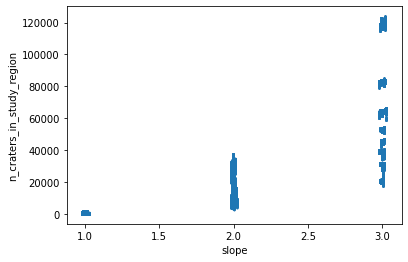

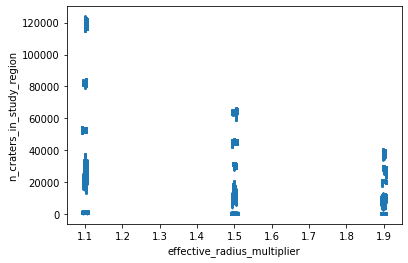

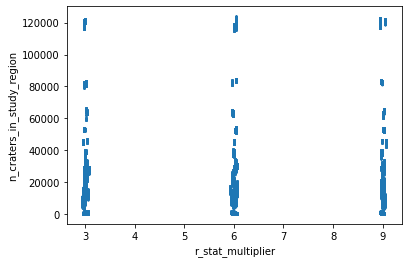

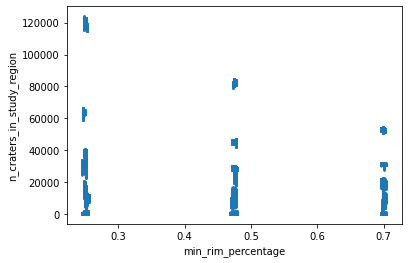

In [6]:
series = train_df[metric]

for iv in ivs:
    plt.scatter(train_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

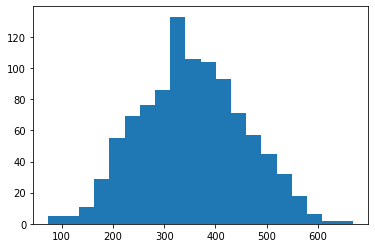

In [7]:
plt.hist(train_df[train_df.simulation_id == 26][metric], bins=20)
plt.show()

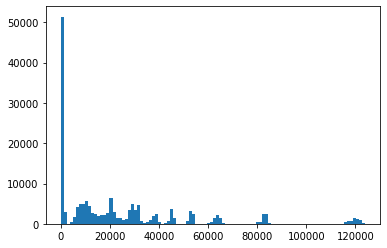

In [8]:
plt.hist(train_df[metric], bins=100)
plt.show()

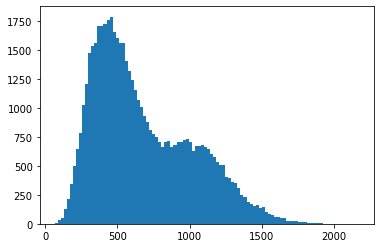

In [9]:
plt.hist(train_df[metric][train_df[metric] < 2500], bins=100)
plt.show()

### Baseline Linear Regression Model

                                OLS Regression Results                               
Dep. Variable:     n_craters_in_study_region   R-squared:                       0.746
Model:                                   OLS   Adj. R-squared:                  0.746
Method:                        Least Squares   F-statistic:                 1.196e+05
Date:                       Sat, 10 Jun 2023   Prob (F-statistic):               0.00
Time:                               18:30:25   Log-Likelihood:            -1.7880e+06
No. Observations:                     162710   AIC:                         3.576e+06
Df Residuals:                         162705   BIC:                         3.576e+06
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

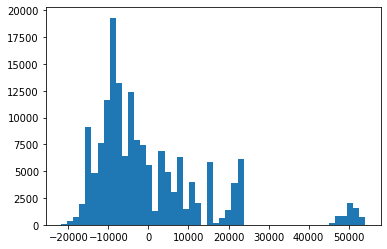

KS test p-value on training residuals: 0.000
AD test on training residuals: 7516.132, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 14229.7136, Test MAPE: 0.5333
Mean model: RMSE: 28413.9867, MAPE: 0.9112
*** Test set 2
Test RMSE: 7381.4233, Test MAPE: 0.7361
Mean model: RMSE: 16408.7308, MAPE: 0.6285


In [10]:
X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                     Generalized Linear Model Regression Results                     
Dep. Variable:     n_craters_in_study_region   No. Observations:               162710
Model:                                   GLM   Df Residuals:                   162705
Model Family:                       Gaussian   Df Model:                            4
Link Function:                           Log   Scale:                      8.5189e+06
Method:                                 IRLS   Log-Likelihood:            -1.5291e+06
Date:                       Sat, 10 Jun 2023   Deviance:                   1.3861e+12
Time:                               18:30:26   Pearson chi2:                 1.39e+12
No. Iterations:                           10   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

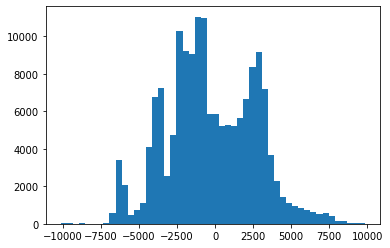

KS test p-value on training residuals: 0.000
AD test on training residuals: 656.708, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 2924.7919, Test MAPE: 0.3612
Mean model: RMSE: 28413.9867, MAPE: 0.9112
*** Test set 2
Test RMSE: 5650.0673, Test MAPE: 0.3594
Mean model: RMSE: 16408.7308, MAPE: 0.6285


In [11]:
X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Gaussian(link=sm.families.links.Log())),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

                     Generalized Linear Model Regression Results                     
Dep. Variable:     n_craters_in_study_region   No. Observations:               162710
Model:                                   GLM   Df Residuals:                   162705
Model Family:                        Poisson   Df Model:                            4
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:            -9.5977e+07
Date:                       Sat, 10 Jun 2023   Deviance:                   1.9021e+08
Time:                               18:30:27   Pearson chi2:                 1.70e+08
No. Iterations:                           29   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

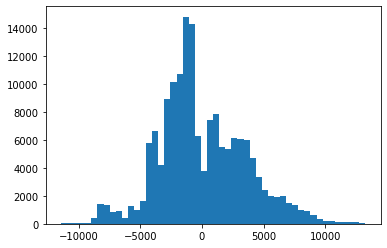

KS test p-value on training residuals: 0.000
AD test on training residuals: 1090.565, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 3499.2571, Test MAPE: 0.3757
Mean model: RMSE: 28413.9867, MAPE: 0.9112
*** Test set 2
Test RMSE: 6087.5674, Test MAPE: 0.3203
Mean model: RMSE: 16408.7308, MAPE: 0.6285


In [12]:
X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Poisson(link=sm.families.links.Log())),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

### With Interactions

                                OLS Regression Results                               
Dep. Variable:     n_craters_in_study_region   R-squared:                       0.960
Model:                                   OLS   Adj. R-squared:                  0.960
Method:                        Least Squares   F-statistic:                 2.800e+05
Date:                       Sat, 10 Jun 2023   Prob (F-statistic):               0.00
Time:                               18:30:28   Log-Likelihood:            -1.6374e+06
No. Observations:                     162710   AIC:                         3.275e+06
Df Residuals:                         162695   BIC:                         3.275e+06
Df Model:                                 14                                         
Covariance Type:                   nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

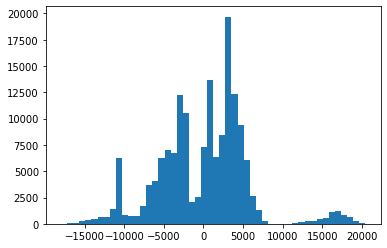

KS test p-value on training residuals: 0.000
AD test on training residuals: 2114.360, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 5562.4448, Test MAPE: 1.4720
Mean model: RMSE: 28413.9867, MAPE: 0.9112
*** Test set 2
Test RMSE: 3430.4682, Test MAPE: 25.5150
Mean model: RMSE: 16408.7308, MAPE: 0.6285


In [13]:
exclude = {}

features = [x for x in ivs if x not in exclude]

X_train = train_df[features]
X_tests = [x[features] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]

model = fit_and_report_statsmodels_model(sm.OLS,
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x, has_constant="add") for x in X_tests],
                                         y_tests,
                                         "LM With All Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

#### Removing Insignificant Variables

                                    OLS Regression Results                                    
Dep. Variable:     n_craters_in_study_region   R-squared (uncentered):                   0.975
Model:                                   OLS   Adj. R-squared (uncentered):              0.975
Method:                        Least Squares   F-statistic:                          8.092e+05
Date:                       Sat, 10 Jun 2023   Prob (F-statistic):                        0.00
Time:                               18:30:28   Log-Likelihood:                     -1.6394e+06
No. Observations:                     162710   AIC:                                  3.279e+06
Df Residuals:                         162702   BIC:                                  3.279e+06
Df Model:                                  8                                                  
Covariance Type:                   nonrobust                                                  
                                                  

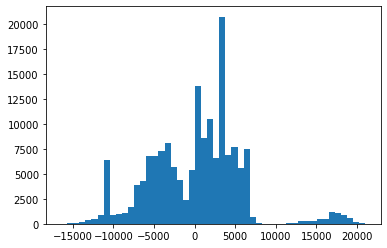

KS test p-value on training residuals: 0.000
AD test on training residuals: 1835.882, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 5625.4186, Test MAPE: 0.7851
Mean model: RMSE: 28413.9867, MAPE: 0.9112
*** Test set 2
Test RMSE: 3055.8067, Test MAPE: 0.8590
Mean model: RMSE: 16408.7308, MAPE: 0.6285


In [14]:
add_const = False

exclude = {
    "slope r_stat_multiplier", # effect size
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "r_stat_multiplier^2", # effect size
    "r_stat_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "const", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(sm.OLS,
                                         sm.add_constant(X_train) if add_const else X_train,
                                         y_train,
                                         [sm.add_constant(x, has_constant="add") if add_const else x for x in X_tests],
                                         y_tests,
                                         "LM With Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [15]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.04290381355844891, 'min_rim_percentage'),
 (0.29530640325875884, 'effective_radius_multiplier^2'),
 (0.29940919041147945, 'effective_radius_multiplier min_rim_percentage'),
 (0.3510503682806768, 'effective_radius_multiplier'),
 (0.7116745407853426, 'slope min_rim_percentage'),
 (0.8060817672552719, 'slope^2'),
 (0.971950848953924, 'slope'),
 (1.0, 'slope effective_radius_multiplier')]

In [16]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

slope                                             0.0
effective_radius_multiplier                       0.0
min_rim_percentage                                0.0
slope^2                                           0.0
slope effective_radius_multiplier                 0.0
slope min_rim_percentage                          0.0
effective_radius_multiplier^2                     0.0
effective_radius_multiplier min_rim_percentage    0.0
dtype: float64

### Trying a Gaussian GLM with Log Link

                     Generalized Linear Model Regression Results                     
Dep. Variable:     n_craters_in_study_region   No. Observations:               162710
Model:                                   GLM   Df Residuals:                   162702
Model Family:                       Gaussian   Df Model:                            7
Link Function:                           Log   Scale:                      1.6216e+06
Method:                                 IRLS   Log-Likelihood:            -1.3942e+06
Date:                       Sat, 10 Jun 2023   Deviance:                   2.6384e+11
Time:                               18:30:32   Pearson chi2:                 2.64e+11
No. Iterations:                           10   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

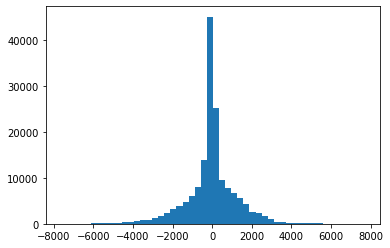

KS test p-value on training residuals: 0.000
AD test on training residuals: 4649.525, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 1356.7243, Test MAPE: 0.1026
Mean model: RMSE: 28413.9867, MAPE: 0.9112
*** Test set 2
Test RMSE: 1525.3084, Test MAPE: 0.1028
Mean model: RMSE: 16408.7308, MAPE: 0.6285


In [17]:
add_const = True

exclude = {
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier", # effect size
    "r_stat_multiplier^2", # effect size
    "slope effective_radius_multiplier", # effect size
    "r_stat_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_glm_model(sm.families.Gaussian(link=sm.families.links.Log()),
                                             sm.add_constant(X_train),
                                             y_train,
                                             [sm.add_constant(x) for x in X_tests],
                                             y_tests,
                                             "GLM With Interactions")

In [18]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.01696395309143993, 'min_rim_percentage'),
 (0.023292386566420416, 'effective_radius_multiplier min_rim_percentage'),
 (0.03229540291523004, 'effective_radius_multiplier^2'),
 (0.08037369956157733, 'slope min_rim_percentage'),
 (0.17009499884903456, 'effective_radius_multiplier'),
 (0.4488343478770589, 'slope^2'),
 (0.827709262745154, 'const'),
 (1.0, 'slope')]

In [19]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

const                                             0.0
slope                                             0.0
effective_radius_multiplier                       0.0
min_rim_percentage                                0.0
slope^2                                           0.0
slope min_rim_percentage                          0.0
effective_radius_multiplier^2                     0.0
effective_radius_multiplier min_rim_percentage    0.0
dtype: float64

### Trying Poisson GLM with log link

                     Generalized Linear Model Regression Results                     
Dep. Variable:     n_craters_in_study_region   No. Observations:               162710
Model:                                   GLM   Df Residuals:                   162702
Model Family:                        Poisson   Df Model:                            7
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:            -8.2177e+06
Date:                       Sat, 10 Jun 2023   Deviance:                   1.4690e+07
Time:                               18:30:34   Pearson chi2:                 1.44e+07
No. Iterations:                           10   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

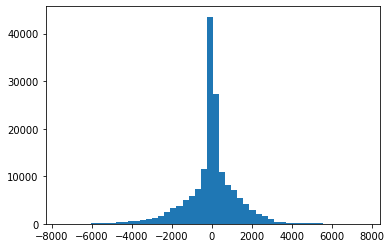

KS test p-value on training residuals: 0.000
AD test on training residuals: 4660.822, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 1368.9870, Test MAPE: 0.1040
Mean model: RMSE: 28413.9867, MAPE: 0.9112
*** Test set 2
Test RMSE: 1529.0124, Test MAPE: 0.1004
Mean model: RMSE: 16408.7308, MAPE: 0.6285


In [20]:
add_const = True

exclude = {
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier", # effect size
    "r_stat_multiplier^2", # effect size
    "slope effective_radius_multiplier", # effect size
    "r_stat_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_glm_model(sm.families.Poisson(link=sm.families.links.Log()),
                                             sm.add_constant(X_train),
                                             y_train,
                                             [sm.add_constant(x) for x in X_tests],
                                             y_tests,
                                             "GLM With Interactions")

In [21]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.018317733356465367, 'min_rim_percentage'),
 (0.021359696913400155, 'effective_radius_multiplier min_rim_percentage'),
 (0.03330073934729167, 'effective_radius_multiplier^2'),
 (0.07752296442017434, 'slope min_rim_percentage'),
 (0.16836963459204102, 'effective_radius_multiplier'),
 (0.45263823323686736, 'slope^2'),
 (0.8078726609986231, 'const'),
 (1.0, 'slope')]

### Trying with degree=3

                                    OLS Regression Results                                    
Dep. Variable:     n_craters_in_study_region   R-squared (uncentered):                   0.997
Model:                                   OLS   Adj. R-squared (uncentered):              0.997
Method:                        Least Squares   F-statistic:                          1.988e+06
Date:                       Sun, 04 Jun 2023   Prob (F-statistic):                        0.00
Time:                               12:36:33   Log-Likelihood:                     -1.4661e+06
No. Observations:                     162710   AIC:                                  2.932e+06
Df Residuals:                         162682   BIC:                                  2.932e+06
Df Model:                                 28                                                  
Covariance Type:                   nonrobust                                                  
                                                  

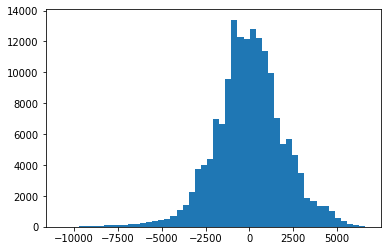

KS test p-value on training residuals: 0.000
AD test on training residuals: 309.154, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 1976.4251, Test MAPE: 0.6175
Mean model: RMSE: 28413.9867, MAPE: 0.9112
*** Test set 2
Test RMSE: 9953.4056, Test MAPE: 1.0061
Mean model: RMSE: 16408.7308, MAPE: 0.6285


In [16]:
exclude = {
    "slope r_stat_multiplier min_rim_percentage", # p-value
    "r_stat_multiplier^2 min_rim_percentage", # effect size
    "const", # effect size
    "effective_radius_multiplier r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier^2", # effect size
    "slope^2 r_stat_multiplier", # effect size
    "slope effective_radius_multiplier r_stat_multiplier", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(sm.OLS,
                                         X_train,
                                         y_train,
                                         X_tests,
                                         y_tests,
                                         "LM With Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [17]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

[(0.001139202955680995, 'slope r_stat_multiplier'),
 (0.00452257251025032, 'effective_radius_multiplier r_stat_multiplier'),
 (0.004610181179857524, 'effective_radius_multiplier^2 r_stat_multiplier'),
 (0.005036315583117413, 'r_stat_multiplier min_rim_percentage^2'),
 (0.005965802041597496, 'r_stat_multiplier min_rim_percentage'),
 (0.008783065732435525, 'effective_radius_multiplier r_stat_multiplier^2'),
 (0.02013515377892186, 'effective_radius_multiplier min_rim_percentage^2'),
 (0.03459950007822628, 'slope min_rim_percentage^2'),
 (0.04767066248938775, 'effective_radius_multiplier min_rim_percentage'),
 (0.05105176819128939, 'effective_radius_multiplier^2 min_rim_percentage'),
 (0.07167215232980906, 'slope min_rim_percentage'),
 (0.07532081464778517, 'slope'),
 (0.1284996560632448, 'effective_radius_multiplier'),
 (0.15127962344256732, 'slope effective_radius_multiplier^2'),
 (0.18297173773376024, 'slope^2 effective_radius_multiplier'),
 (0.19119307111783465, 'slope effective_radius

In [18]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

effective_radius_multiplier r_stat_multiplier            2.034017e-15
slope r_stat_multiplier                                  3.928145e-25
effective_radius_multiplier^2 r_stat_multiplier          6.521776e-31
r_stat_multiplier min_rim_percentage^2                   2.717689e-38
r_stat_multiplier min_rim_percentage                     1.264164e-50
slope                                                    9.050313e-67
effective_radius_multiplier r_stat_multiplier^2         5.593021e-107
effective_radius_multiplier                             1.277164e-163
effective_radius_multiplier^2                           1.288467e-174
effective_radius_multiplier^3                           7.102117e-190
slope^3                                                 4.684304e-218
r_stat_multiplier^2                                      0.000000e+00
slope effective_radius_multiplier                        0.000000e+00
r_stat_multiplier                                        0.000000e+00
r_stat_multiplier^3 

### Plotting Prediction Intervals

In [32]:
def read_simulation_parquet(path: Path, sample_cadence: int) -> pd.DataFrame:
    df = pd.read_parquet(path, columns=ivs + dvs + ["simulation_id", "n_craters_added_in_study_region"])
    return df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()


def score_model(model,
                df: pd.DataFrame,
                alphas: list[float],
                metric: str,
                inverse_transform,
                add_constant: bool) -> pd.DataFrame:
    X = df[ivs]
    X = min_max_scaler.transform(X)
    X = pd.DataFrame(X, columns=min_max_scaler.get_feature_names_out())
    
    X = poly_transform.transform(X)
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())

    pred_df = df.reset_index(drop=True).copy()
    for feature_name in poly_transform.get_feature_names_out():
        pred_df[feature_name] = X[feature_name]
    
    X = X[feature_names].copy()
    y = df[metric]
    
    if add_constant:
        X = sm.add_constant(X, has_constant="add")
    pred_df["actual"] = list(y)
    pred_df["n_craters"] = list(df.index)
    
    is_glm = type(model) == statsmodels.genmod.generalized_linear_model.GLMResultsWrapper
    
    if is_glm:
        link = model.family.link
        predictions = inverse_transform(model.predict(X))
        resid = link(pred_df.actual) - link(predictions)
        var_pred_mean = (X * np.dot(model.cov_params(), X.T).T).sum(1)
        var_resid = resid.var()
        sigma = np.sqrt(var_pred_mean + var_resid)
        n = pred_df.shape[0]
    else:
        predictions = inverse_transform(model.get_prediction(X))
    
    for alpha in alphas:
        if is_glm:
            pred_df[f"alpha_{alpha:.2f}"] = link.inverse(link(predictions) - sigma * stats.distributions.t.ppf(1 - alpha, n - 2) * np.sqrt(1 + 1 / n))
        else:
            ci_lower = predictions.conf_int(obs=True, alpha=alpha*2)[:,0]
            pred_df[f"alpha_{alpha:.2f}"] = inverse_transform(ci_lower)
    
    return pred_df


def score_model_from_parquet_file(model,
                                  parquet_path: Path,
                                  sample_cadence: int,
                                  alphas: list[float],
                                  metric: str,
                                  inverse_transform,
                                  add_constant: bool) -> pd.DataFrame:
    df = read_simulation_parquet(parquet_path, sample_cadence)
    return score_model(model, df, alphas, metric, inverse_transform, add_constant)
        

def plot_holdout_sim_ci(model,
                        alphas: list[float],
                        parquet_path: Path,
                        sample_cadence: int,
                        metric: str,
                        inverse_transform,
                        add_constant):
    pred_df = score_model_from_parquet_file(model, parquet_path, sample_cadence, alphas, metric, inverse_transform, add_constant)
    
    # Show params
    print(f"Simulation parameters: {pred_df[ivs].iloc[0]}")

    ns_max = 100000
    plt.plot(pred_df.n_craters_added_in_study_region.iloc[:ns_max],
             pred_df[metric].iloc[:ns_max])
    plt.xlabel("$N_G$")
    plt.ylabel("$A_d$")
    plt.show()
    
    fig = go.Figure()

    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    
    for alpha in alphas:
        fig.add_scatter(x=pred_df["n_craters"],
                        y=pred_df[f"alpha_{alpha:.2f}"],
                        mode="lines",
                        name=f"Pred {int(alpha*100)} Percentile")

    fig.update_layout(
        xaxis_title="$N_G$",
        yaxis_title=metric
    )

    fig.show()
    
    
def report_alphas(model,
                  df: pd.DataFrame,
                  alphas: list[float],
                  metric: str,
                  inverse_transform,
                  add_constant: bool):
    pred_df = score_model(model, df, alphas, metric, inverse_transform, add_constant)
    
    # Report alphas for only the last third
    pred_df = pred_df.iloc[pred_df.shape[0] // 3 * 2:]
    
    for alpha in alphas:
        percent_below = (pred_df.actual < pred_df[f"alpha_{alpha:.2f}"]).mean() * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")
        

def report_alphas_for_parquets(model,
                               parquet_paths: list[Path],
                               sample_cadence: int,
                               alphas: list[float],
                               metric: str,
                               inverse_transform,
                               add_constant: bool):
    n_below = defaultdict(lambda: 0)
    n = defaultdict(lambda: 0)
    for path in parquet_paths:
        pred_df = score_model_from_parquet_file(model, path, sample_cadence, alphas, metric, inverse_transform, add_constant)
        
        # Report alphas for only the last third
        pred_df = pred_df.iloc[pred_df.shape[0] // 3 * 2:]
        
        for alpha in alphas:
            n_below[alpha] += (pred_df.actual < pred_df[f"alpha_{alpha:.2f}"]).sum()
            n[alpha] += pred_df.shape[0]
    
    for alpha in alphas:
        percent_below = n_below[alpha] / n[alpha] * 100
        print(f"Alpha = {alpha:.2f}, % below: {percent_below:.2f}")

In [33]:
# Load up a subset of the test DFs
np.random.seed(123)

alphas = [0.01, 0.05, 0.25, 0.5]
sample_cadence = 100
in_ccd_paths = list(Path(base_path).glob("simulation_*.parquet"))
outside_ccd_paths = list(Path(base_path_holdout).glob("simulation_*.parquet"))

                     Generalized Linear Model Regression Results                     
Dep. Variable:     n_craters_in_study_region   No. Observations:               162710
Model:                                   GLM   Df Residuals:                   162702
Model Family:                       Gaussian   Df Model:                            7
Link Function:                           Log   Scale:                      1.6216e+06
Method:                                 IRLS   Log-Likelihood:            -1.3942e+06
Date:                       Sat, 10 Jun 2023   Deviance:                   2.6384e+11
Time:                               18:32:20   Pearson chi2:                 2.64e+11
No. Iterations:                           10   Pseudo R-squ. (CS):              1.000
Covariance Type:                   nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

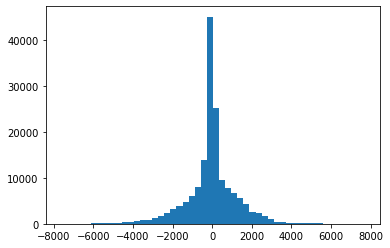

KS test p-value on training residuals: 0.000
AD test on training residuals: 4649.525, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 1356.7243, Test MAPE: 0.1026
Mean model: RMSE: 28413.9867, MAPE: 0.9112
*** Test set 2
Test RMSE: 1525.3084, Test MAPE: 0.1028
Mean model: RMSE: 16408.7308, MAPE: 0.6285
Kurtosis:  3.7303674968116596


In [34]:
add_const = True

exclude = {
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier", # effect size
    "r_stat_multiplier^2", # effect size
    "slope effective_radius_multiplier", # effect size
    "r_stat_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]
y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_glm_model(sm.families.Gaussian(link=sm.families.links.Log()),
                                             sm.add_constant(X_train),
                                             y_train,
                                             [sm.add_constant(x) for x in X_tests],
                                             y_tests,
                                             "GLM With Interactions")

feature_names = [x for x in model.model.exog_names if x != "const"]
data = score_model(model, train_df, alphas, metric, lambda x: x, True)
print(f"Kurtosis: ", stats.kurtosis(data.actual - data["alpha_0.50"]))

In [35]:
feature_names = [x for x in model.model.exog_names if x != "const"]

10
Simulation parameters: slope                          0.986364
effective_radius_multiplier    0.991116
r_stat_multiplier              0.987785
min_rim_percentage             0.009747
Name: 0, dtype: float64


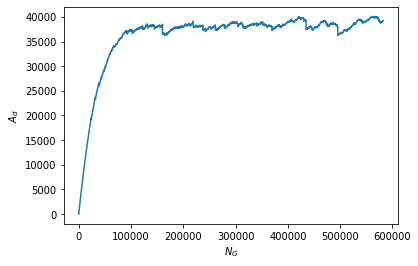

11
Simulation parameters: slope                          0.497845
effective_radius_multiplier    0.991116
r_stat_multiplier              0.498734
min_rim_percentage             0.990895
Name: 0, dtype: float64


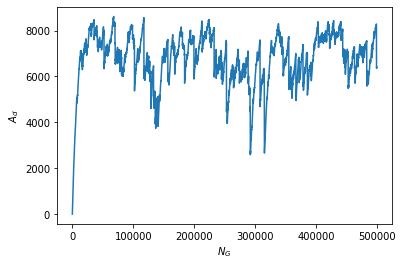

12
Simulation parameters: slope                          0.986364
effective_radius_multiplier    0.500548
r_stat_multiplier              0.009682
min_rim_percentage             0.990895
Name: 0, dtype: float64


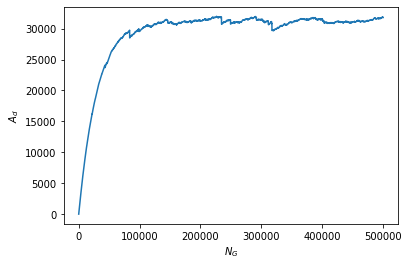

13
Simulation parameters: slope                          0.497845
effective_radius_multiplier    0.500548
r_stat_multiplier              0.987785
min_rim_percentage             0.009747
Name: 0, dtype: float64


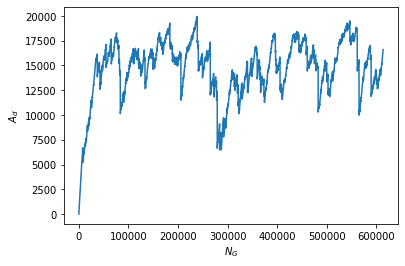

14
Simulation parameters: slope                          0.009327
effective_radius_multiplier    0.009981
r_stat_multiplier              0.009682
min_rim_percentage             0.009747
Name: 0, dtype: float64


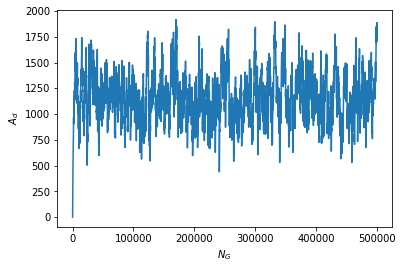

In [36]:
# Visualize CIs for a few in-CCD simulations
for x in range(10, 15):
    print(x)
    plot_holdout_sim_ci(model, alphas, in_ccd_paths[x], sample_cadence, metric, inverse_transform=lambda x: x, add_constant=True)

10
Simulation parameters: slope                          0.737441
effective_radius_multiplier    0.749535
r_stat_multiplier              0.738751
min_rim_percentage             0.828389
Name: 0, dtype: float64


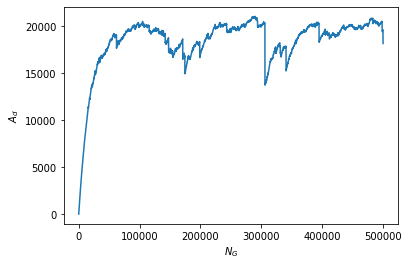

11
Simulation parameters: slope                          0.745171
effective_radius_multiplier    0.747812
r_stat_multiplier              0.252524
min_rim_percentage             0.286815
Name: 0, dtype: float64


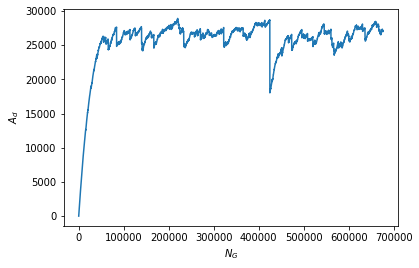

12
Simulation parameters: slope                          0.255893
effective_radius_multiplier    0.743409
r_stat_multiplier              0.741341
min_rim_percentage             0.827450
Name: 0, dtype: float64


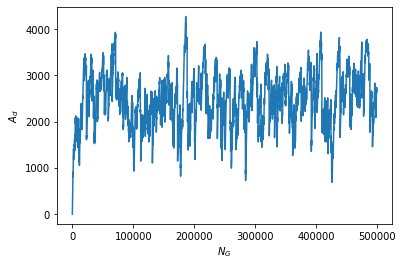

13
Simulation parameters: slope                          0.253586
effective_radius_multiplier    0.745832
r_stat_multiplier              0.254208
min_rim_percentage             0.282288
Name: 0, dtype: float64


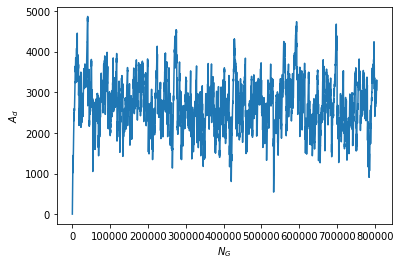

14
Simulation parameters: slope                          0.742547
effective_radius_multiplier    0.257794
r_stat_multiplier              0.257088
min_rim_percentage             0.826457
Name: 0, dtype: float64


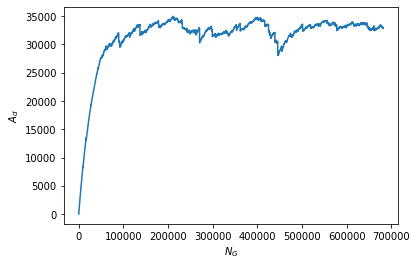

In [37]:
# Visualize CIs for a few simulations outside the CCD
alphas = [0.01, 0.05, 0.25, 0.5]
for x in range(10, 15):
    print(x)
    plot_holdout_sim_ci(model, alphas, outside_ccd_paths[x], sample_cadence, metric, inverse_transform=lambda x: x, add_constant=True)

In [38]:
# Report for train data
report_alphas(model, train_df, alphas, metric, lambda x: x, True)

Alpha = 0.01, % below: 4.54
Alpha = 0.05, % below: 8.86
Alpha = 0.25, % below: 22.03
Alpha = 0.50, % below: 52.80


In [39]:
# Report for in-CCD test sims
report_alphas_for_parquets(model, in_ccd_paths, sample_cadence, alphas, metric, lambda x: x, True)

Alpha = 0.01, % below: 1.03
Alpha = 0.05, % below: 3.19
Alpha = 0.25, % below: 13.47
Alpha = 0.50, % below: 50.48


In [40]:
# Report for outside-CCD test sims
report_alphas_for_parquets(model, outside_ccd_paths, sample_cadence, alphas, metric, lambda x: x, True)

Alpha = 0.01, % below: 1.17
Alpha = 0.05, % below: 3.85
Alpha = 0.25, % below: 18.23
Alpha = 0.50, % below: 67.64


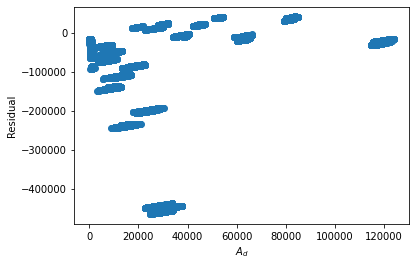

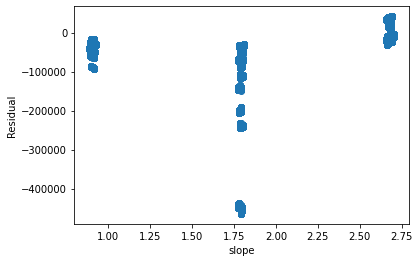

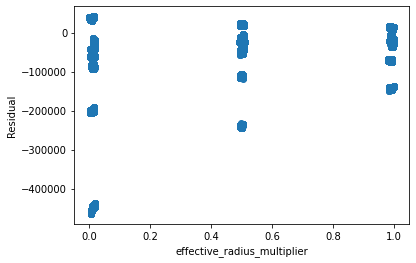

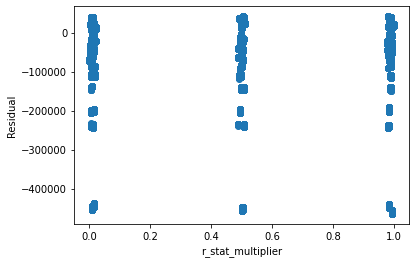

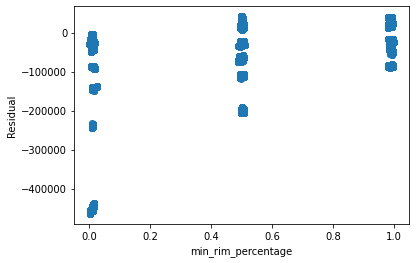

In [123]:
# Model residuals for training data
pred_df = score_model(model, train_df, alphas, metric, lambda x: x, True)

resid = pred_df.actual - pred_df["alpha_0.50"]

plt.scatter(pred_df[metric], resid)
plt.xlabel("$A_d$")
plt.ylabel("Residual")
plt.show()

for iv in ivs:
    if iv in pred_df.columns:
        plt.scatter(pred_df[iv], resid)
        plt.xlabel(iv)
        plt.ylabel("Residual")
        plt.show()